## Crime Rhythm Maps

Description


In [1]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [2]:
%%time

# Get a URL from : https://docs.airnowapi.org/HistoricalObservationsByZip/query

aqi_url = 'http://www.airnowapi.org/aq/observation/zipCode/historical/?format=text/csv&zipCode=92109&date={}T00-0000&distance=25&API_KEY=D17CC5F9-F48F-459E-9EDF-0A94B807B5DF'

frames = []
for e in pd.date_range(start='2019-03-01', end='2019-05-01'):
    u = aqi_url.format(e.date())
    frames.append(pd.read_csv(u))



CPU times: user 232 ms, sys: 20.7 ms, total: 253 ms
Wall time: 6.83 s


In [3]:
df = pd.concat(frames)
df['date'] = pd.to_datetime(df.DateObserved)
df['AQI'] = pd.to_numeric(df.AQI)
df = df.groupby(['date','ParameterName']).AQI.mean().to_frame()
df = df.unstack()
df.columns = ['ozone','pm25']

Text(0, 0.5, 'Air Quality Index (AQI)')

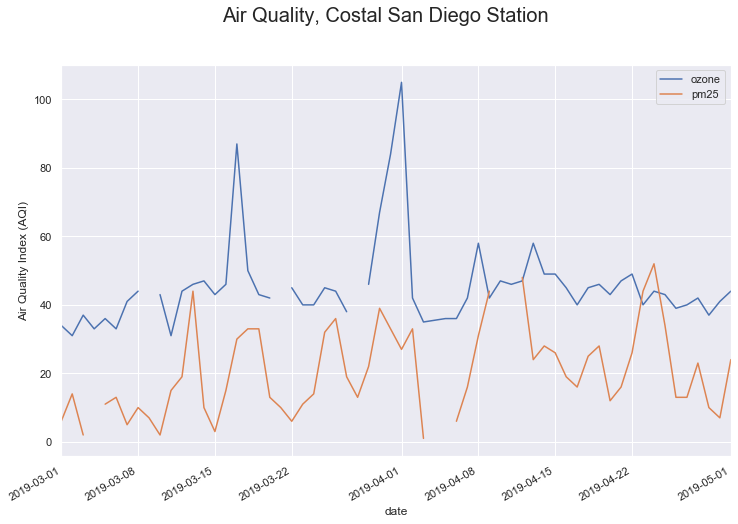

In [4]:
fig, ax = plt.subplots(figsize=(12,8))
df.plot(ax=ax)
fig.suptitle("Air Quality, Costal San Diego Station", fontsize=20);
ax.set_ylabel("Air Quality Index (AQI)")

In [5]:
%%time
baseu = 'http://www.airnowapi.org/aq/data/?startDate={sy}-{sm}-01T23&endDate={ey}-{em}-02T00&parameters=OZONE,PM25,PM10,CO,NO2,SO2&BBOX=-117.390585,32.574297,-116.879721,33.003764&dataType=B&format=text/csv&verbose=0&nowcastonly=0&includerawconcentrations=0&API_KEY=D17CC5F9-F48F-459E-9EDF-0A94B807B5DF'
columns='lat lon date measure concentration units aqi category'.split()

frames = []
urls = []
for y in (2019, 2020):
    for m in (2,3,4):
        u = baseu.format(sy=y, sm=m, ey=y, em=m+1)
        urls.append(u)
        frames.append(pd.read_csv(u, header=None, names=columns))




CPU times: user 85.5 ms, sys: 33.3 ms, total: 119 ms
Wall time: 28.3 s


In [6]:
aqi = pd.concat(frames)
aqi['date'] = pd.to_datetime(aqi.date)
aqi = aqi[['date','measure','aqi']].groupby(['date','measure']).mean().unstack()
aqi.columns='ozone pm25'.split()

aqi19 = aqi.loc['2019-01-01':'2019-05-01'].copy().reset_index()
aqi19['date'] = (aqi19.date-pd.Timestamp('2019-01-01')).dt.days
aqi19 = aqi19.set_index('date').rename(columns={'ozone':'ozone19','pm25':'pm2519'})

aqi20 = aqi.loc['2020-01-01':'2020-05-01'].copy().reset_index()
aqi20['date'] = (aqi20.date-pd.Timestamp('2020-01-01')).dt.days
aqi20 = aqi20.set_index('date').rename(columns={'ozone':'ozone20','pm25':'pm2520'})
aqi = aqi19[['ozone19', 'pm2519']].join(aqi20[['ozone20', 'pm2520']])
aqi.head()

,ozone19,pm2519,ozone20,pm2520
date,,,,
31,31.25,39.5,34.4,31.666667
32,29.50,39.5,32.6,31.333333
32,29.50,39.5,30.0,31.333333
32,29.50,39.5,27.0,31.666667
32,29.50,39.5,24.0,31.666667


In [7]:

aqi.stack().to_frame().reset_index()

,date,level_1,0
0,31,ozone19,31.250000
1,31,pm2519,39.500000
2,31,ozone20,34.400000
3,31,pm2520,31.666667
4,32,ozone19,29.500000
...,...,...,...
204599,120,pm2520,54.333333
204600,120,ozone19,44.750000
204601,120,pm2519,29.000000
204602,120,ozone20,50.600000


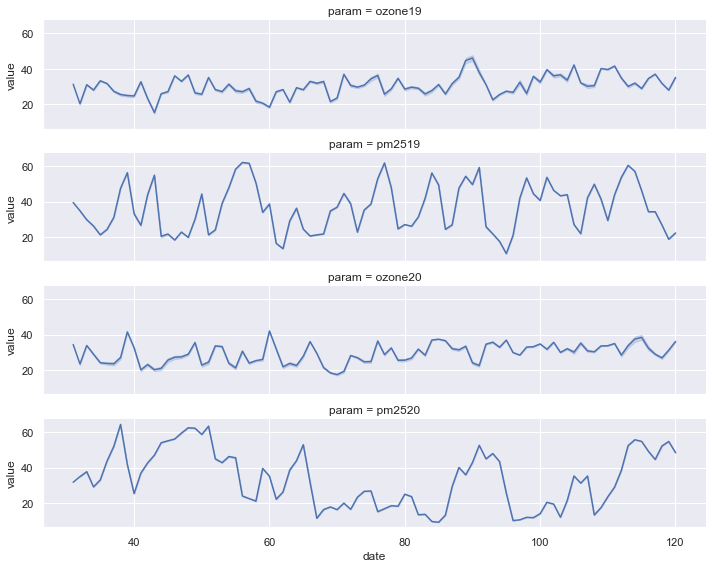

In [8]:
t = aqi.stack().to_frame().reset_index()
t.columns = 'date param value'.split()

grid = sns.FacetGrid(t, col="param", col_wrap=1, height=2, aspect=5)

grid.map(sns.lineplot, 'date','value')

In [9]:
df

,ozone,pm25
date,,
2019-03-01,34.0,6.0
2019-03-02,31.0,14.0
2019-03-03,37.0,2.0
2019-03-04,33.0,NaN
2019-03-05,36.0,11.0
...,...,...
2019-04-27,40.0,13.0
2019-04-28,42.0,23.0
2019-04-29,37.0,10.0
